<div class="alert alert-warning">
    
<b>Disclaimer:</b> 

The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
    
</div>

# Isotropic Rotational Diffusion &lowast; Resolution with bumps

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the isotropic rotational diffusion model <b>IsotropicRotationalDiffusion</b> to perform some 
fits using <a href="https://github.com/bumps/bumps">bumps</a> .
</div>

The **reference data** were generated using the above model with the following parameters:  
- Radius = 1.10 &#x212B;  
- $D_{rot}$ = 0.125 meV  

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data were sampled randomly from a Poisson distribution.

The data do not have a background.

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "meV", 
                       'q': "1/Angstrom", 
                       'DR': "meV", 
                       'radius': "Angstrom", 
                       'scale': "unit_of_signal.meV",
                       'center': "meV"}

## Import required libraries

In [2]:
from __future__ import print_function

# for interactivity (plots, buttons...)
import ipywidgets

import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
import bumps.names as bmp
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

## Setting of fitting

### Import reference data

In [3]:
path_to_data = './data/'

# Read the sample
with h5py.File(path_to_data + 'IsoRot_Sample.hdf', 'r') as f:
    hw = f['entry1']['data1']['X'][:]
    q = f['entry1']['data1']['Y'][:]
    unit_w = f['entry1']['data1']['X'].attrs['long_name']
    unit_q = f['entry1']['data1']['Y'].attrs['long_name']
    sqw = np.transpose(f['entry1']['data1']['DATA'][:])
    err = np.transpose(f['entry1']['data1']['errors'][:])

# Read resolution
with h5py.File(path_to_data + 'IsoRot_Resol.hdf', 'r') as f:
    res = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

# Fitting model 
def model_convol(x, q, scale=1, center=0, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwIsotropicRotationalDiffusion(x, q, scale, center, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

### Display units of input data
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [4]:
print(f"The names and units of `w` (`x`axis) and `q` are: {unit_w[0].decode()} and {unit_q[0].decode()}, respectively.")

The names and units of `w` (`x`axis) and `q` are: X and Y, respectively.


### Create fitting model

In [5]:
# Fit
Model = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q)):

    # Bumps fitting model
    Modelq = bmp.Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, radius=1.0, DR=0.1, resolution=res[:, i])
    Modelq.scale.range(0, 1e5)
    Modelq.center.range(-0.1, 0.1)
    Modelq.radius.range(0, 3)
    Modelq.DR.range(0, 2)
    
    # Q-independent parameters
    if i == 0:
        QR = Modelq.radius
        QDR = Modelq.DR
    else:
        Modelq.radius = QR
        Modelq.DR = QDR
    Model.append(Modelq)
        
problem = bmp.FitProblem(Model)

### Choice of minimizer for bumps

In [6]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px'))

w_choice_minimizer

Dropdown(description='Minimizer:', layout=Layout(height='40px'), options=('Levenberg-Marquardt', 'Nelder-Mead …

### Setting for running bumps

In [7]:
steps_fitting = ipywidgets.IntText(
    value=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', style=DescriptionStyle(description_width='initi…

Initial chisq 1067.0559(62)


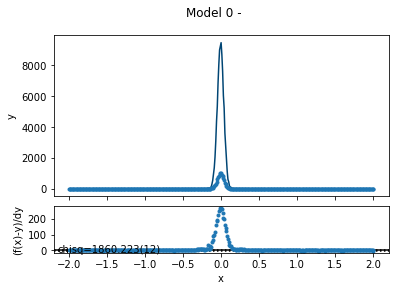

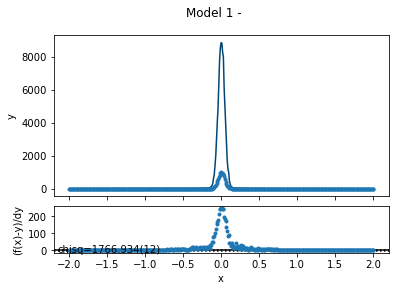

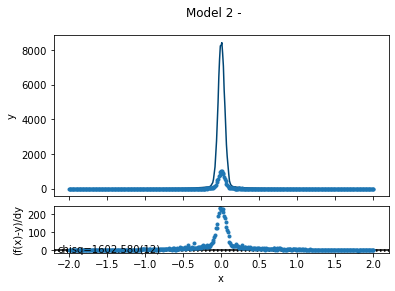

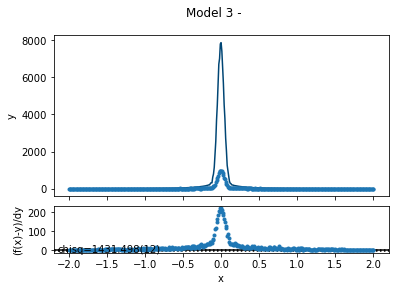

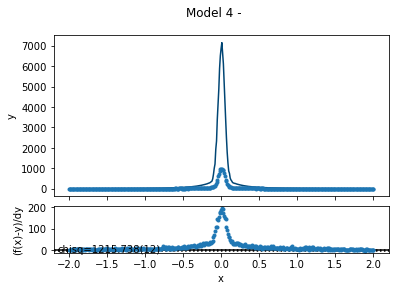

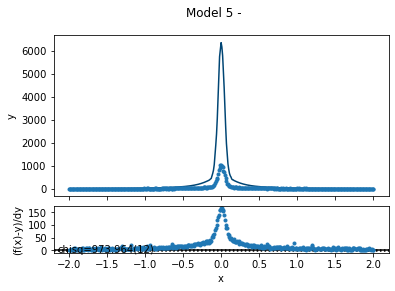

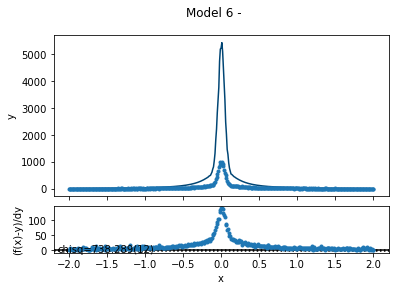

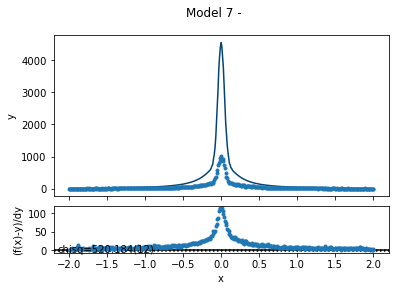

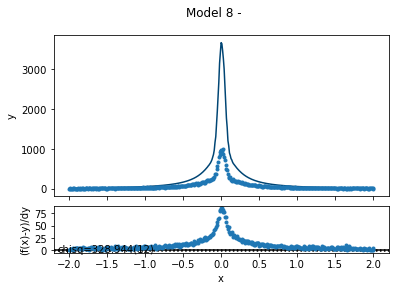

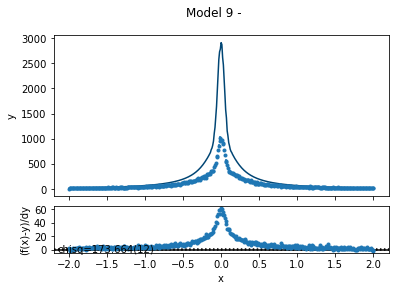

In [8]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot();

## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [9]:
result = fit(problem, 
             method=options_dict[w_choice_minimizer.value], 
             steps=int(steps_fitting.value))

## Showing the results

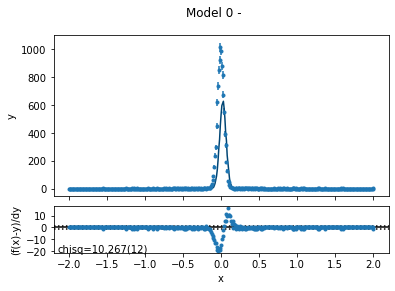

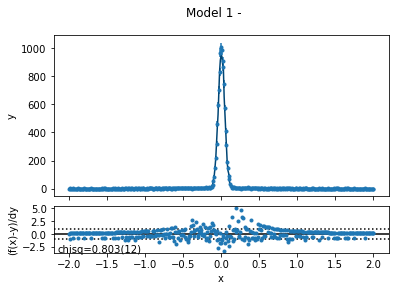

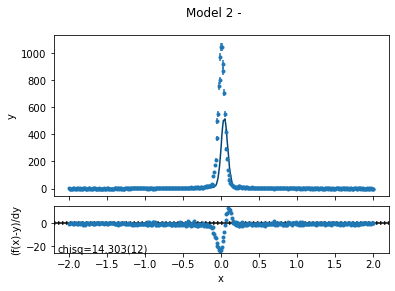

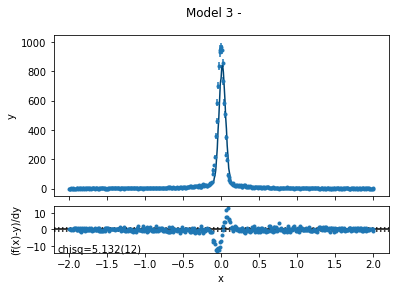

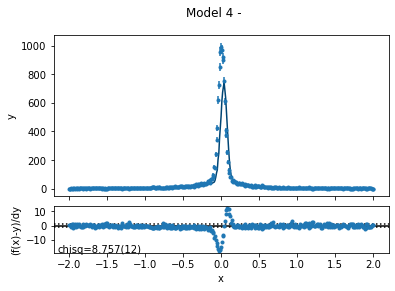

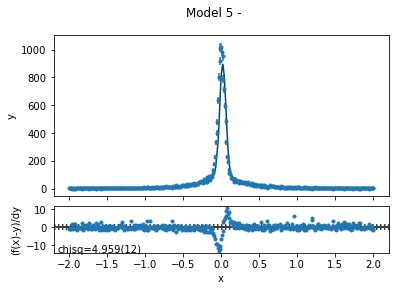

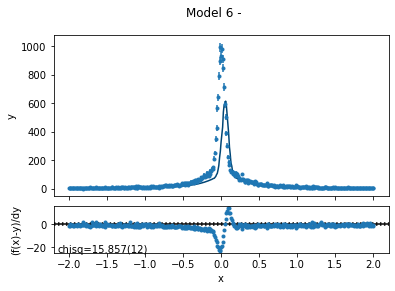

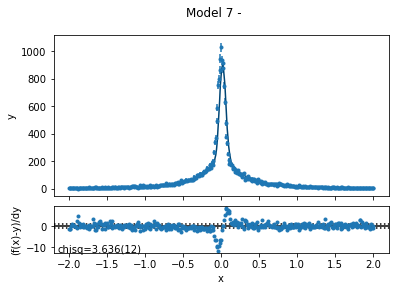

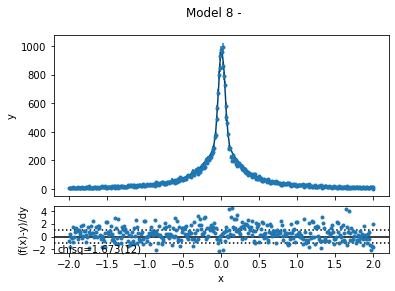

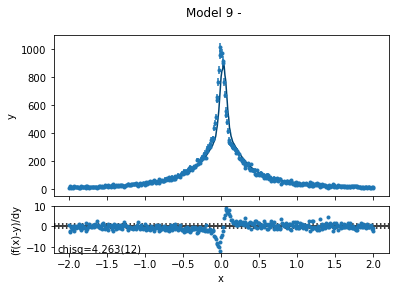

In [10]:
problem.plot()

In [11]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty(v, dv))

final chisq 7.0033(62)
DR : 0.1194(10) meV
center : 33(53)e-3 meV
radius : 1.1355(28) Angstrom
scale : 66.65(82) unit_of_signal.meV
center : 0.004(12) meV
scale : 108.8(11) unit_of_signal.meV
center : 37(16)e-3 meV
scale : 62.95(82) unit_of_signal.meV
center : 0.0170(73) meV
scale : 114.0(11) unit_of_signal.meV
center : 0.0325(67) meV
scale : 113.9(11) unit_of_signal.meV
center : 0.0225(44) meV
scale : 162.1(13) unit_of_signal.meV
center : 0.0526(55) meV
scale : 137.6(13) unit_of_signal.meV
center : 0.0232(31) meV
scale : 258.3(17) unit_of_signal.meV
center : 0.1(16)e-3 meV
scale : 373.3(20) unit_of_signal.meV
center : 0.0347(23) meV
scale : 465.6(23) unit_of_signal.meV
